In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
table_path_fstring = "/home/ebrahim/data/abcd/Package_1200530/{}.txt"
dict_path_fstring = "/home/ebrahim/data/abcd/abcd-4.0-data-dictionaries/{}.csv"

def read_abcd_table(table_name):
    table_path = table_path_fstring.format(table_name)
    dict_path = dict_path_fstring.format(table_name)
    data_dictionary = pd.read_csv(dict_path, index_col='ElementName')
    df = pd.read_csv(table_path, sep='\t', header=0, skiprows=[1])
    return df, data_dictionary

In [3]:
# Load mental health data and demographic data
mh_tab, mh_dd = read_abcd_table("abcd_ksad01") # Mental health
demo_tab, demo_dd = read_abcd_table("pdem02") # Demographic
mri_tab, mri_dd = read_abcd_table('abcd_mri01') # Scanner info
lt_tab, lt_dd = read_abcd_table('abcd_lt01') # Study site info

In [4]:
# Verify they have the exact same number of subjects
assert(len(mh_tab.subjectkey.unique()) == len(demo_tab.subjectkey.unique()))
assert(len(lt_tab.subjectkey.unique()) == len(demo_tab.subjectkey.unique()))

# Except MRI info is missing some subjects
print(len(lt_tab.subjectkey.unique()) - len(mri_tab.subjectkey.unique()), "subjects do not show up in scanner info table.")

44 subjects do not show up in scanner info table.


In [5]:
# Drop duplicates (for some reason these tables have duplicated rows)
demo_tab = demo_tab.drop_duplicates()
mri_tab = mri_tab.drop_duplicates()
lt_tab = lt_tab.drop_duplicates()
mh_tab = mh_tab.drop_duplicates()

In [6]:
# Function to help take stratified samples
def take_sample_stratified_by(df, by, frac):
    return df.groupby(by, as_index=False, group_keys=False).apply(lambda x : x.sample(frac=frac))

In [7]:
# example taking sample stratified by gender
take_sample_stratified_by(demo_tab, ['demo_gender_id_v2'], 0.005).demo_gender_id_v2.value_counts()

1.0    31
2.0    28
Name: demo_gender_id_v2, dtype: int64

In [8]:
# Let's see how many people ended up at multiple different sites
num_sites = lt_tab.groupby(['subjectkey']).site_id_l.agg(lambda x : x.nunique())
num_sites.value_counts()

1    11719
2      152
3        5
Name: site_id_l, dtype: int64

Hmm so there are 157 people who ended up at more than one study site.
So if we choose to stratify our sampling by study site then we'd have to do it at the "event" level and not at the "subject" level.

In [9]:
# Let's see how many people ended up with multiple different scanner models
num_scanners = mri_tab.groupby(['subjectkey']).mri_info_manufacturersmn.agg(lambda x : x.nunique())
num_scanners.value_counts()

1    11367
2      465
Name: mri_info_manufacturersmn, dtype: int64

So 465 people had scans with multiple different scanner models. If we choose to stratify our sampling by scanner model then we'd have to do it at the "event" level and not at the "subject" level.

Or we can just drop the subjects that changes scanners or sites; they are a small minority anyway.

Next we merge the site and scanner info into demo tab to a create a new table that we will sample from:

In [10]:
# df shall be the filtered table we will sample from
df = demo_tab.set_index('subjectkey')
rows_before_filtering = len(df)
df['num_scanners'] = num_scanners
df = df[df.num_scanners==1] # drop the 465 subjects who had 2 scanner types, and the 44 who didn't have any
df['num_sites'] = num_sites
df = df[df.num_sites == 1] # drop the 91 people who went to more than one study site (despite same scanner)
rows_dropped = rows_before_filtering - len(df)
print(f"Dropped {rows_dropped} subjects that had either multiple scanners or multiple sites.")
mri_info_manufacturersmn = mri_tab.groupby('subjectkey').mri_info_manufacturersmn.agg(lambda x : x.iloc[0])
df = df.merge(right=mri_info_manufacturersmn, how='left', left_index=True, right_on='subjectkey')
site_id_l = lt_tab.groupby(['subjectkey']).site_id_l.agg(lambda x : x.iloc[0])
df = df.merge(right=site_id_l, how='left', left_index=True, right_on='subjectkey')

Dropped 600 subjects that had either multiple scanners or multiple sites.


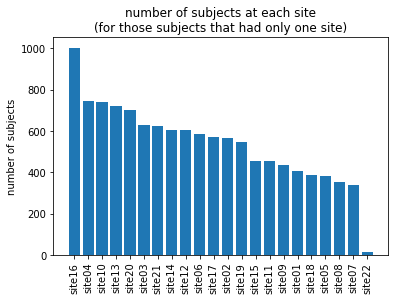

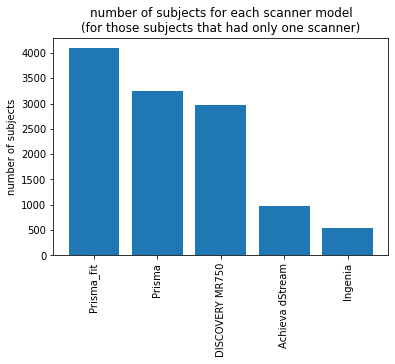

In [11]:
# Look at these plots of site and scanner model distribution now, so we can compare before and after sampling
site_id_val_counts = site_id_l.value_counts()
plt.bar(range(len(site_id_val_counts)), site_id_val_counts)
plt.xticks(ticks = range(len(site_id_val_counts)), labels=site_id_val_counts.index, rotation='vertical')
plt.ylabel('number of subjects')
plt.title("number of subjects at each site\n(for those subjects that had only one site)")
plt.show()

scanner_val_counts = mri_info_manufacturersmn.value_counts()
plt.bar(range(len(scanner_val_counts)), scanner_val_counts)
plt.xticks(ticks = range(len(scanner_val_counts)), labels=scanner_val_counts.index, rotation='vertical')
plt.ylabel('number of subjects')
plt.title("number of subjects for each scanner model\n(for those subjects that had only one scanner)")
plt.show()

Let's now decide how to stratify the sample we will take.

In [12]:
stratify_by = [
    'demo_gender_id_v2', # Gender identity
    'demo_brthdat_v2', # Baseline age
    'site_id_l', # Study site
    'mri_info_manufacturersmn', # Scanner model
]

In [13]:
# Finally, take the stratified sample, reserving 20% (also stratified) of it as a test set

sample = take_sample_stratified_by(df, stratify_by, 0.03)
sample_test = take_sample_stratified_by(sample, stratify_by, 0.2)
sample_nontest = sample.drop(sample_test.index)

In [14]:
# Make sure to exclude from test set any subjects that happene to be part of previous exploration

forbidden_subjects = set(pd.read_csv('../01.0_abcd_sample/sampled_subjectkeys.csv').subjectkey)
to_drop = forbidden_subjects.intersection(sample_test.index)
sample_test = sample_test.drop(to_drop)
print(f"Dropped {len(to_drop)} subjects for test set.")

Dropped 0 subjects for test set.


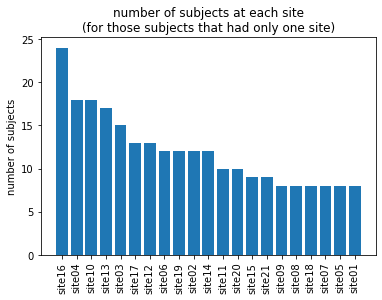

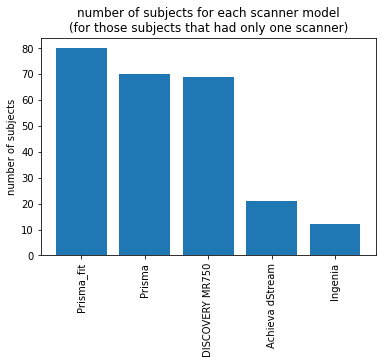

In [15]:
# Examine the same histograms as above but now for the stratified sample, just to
# verify that stratification is working as expected
# Look at these plots of site and scanner model distribution now, so we can compare before and after sampling
site_id_val_counts = sample_nontest.site_id_l.value_counts()
plt.bar(range(len(site_id_val_counts)), site_id_val_counts)
plt.xticks(ticks = range(len(site_id_val_counts)), labels=site_id_val_counts.index, rotation='vertical')
plt.ylabel('number of subjects')
plt.title("number of subjects at each site\n(for those subjects that had only one site)")
plt.show()

scanner_val_counts = sample_nontest.mri_info_manufacturersmn.value_counts()
plt.bar(range(len(scanner_val_counts)), scanner_val_counts)
plt.xticks(ticks = range(len(scanner_val_counts)), labels=scanner_val_counts.index, rotation='vertical')
plt.ylabel('number of subjects')
plt.title("number of subjects for each scanner model\n(for those subjects that had only one scanner)")
plt.show()

In [16]:
table_path = table_path_fstring.format("fmriresults01")
dmri_df = pd.read_csv(table_path, sep='\t', header=0, skiprows=[1])
dmri_df = dmri_df.drop_duplicates() # This one also has duplicated rows

In [17]:
# For each subject, randomly pick from among their interviews
# (baseline or 2 year follow up. keep in mind that some subjects only have one scan though,
# and some have no scans so we lose those subjects)
# (also keep in mind that some subjects have multiple scans within the same interview, so
# the resulting tables below are not unique on subjectid)
def randomly_pick_interview_date_within_each_subject(df):
    random_choices = df[['subjectkey','interview_date']].drop_duplicates().groupby('subjectkey', as_index=False).agg(lambda x : x.sample())
    return df.set_index(['subjectkey','interview_date']).loc[random_choices.itertuples(index=False)].reset_index()
sample_nontest_fmriresults01 = randomly_pick_interview_date_within_each_subject(dmri_df.loc[dmri_df.subjectkey.isin(sample_nontest.index)])
sample_test_fmriresults01 = randomly_pick_interview_date_within_each_subject(dmri_df.loc[dmri_df.subjectkey.isin(sample_test.index)])

sample_nontest_fmriresults01.to_csv('sampled_nontest_fmriresults01.csv')
sample_test_fmriresults01.to_csv('sampled_test_fmriresults01.csv')

# Save the subject keys for future reference
test_subjectkeys = sample_test_fmriresults01.subjectkey.drop_duplicates()
nontest_subjectkeys = sample_nontest_fmriresults01.subjectkey.drop_duplicates()
test_subjectkeys.to_csv('sampled_subjectkeys_test.csv',index=False)
nontest_subjectkeys.to_csv('sampled_subjectkeys_nontest.csv',index=False)

print("Here are the final counts:")
print(f"Number of subjects in non-test set: {len(nontest_subjectkeys)}")
print(f"Number of files in non-test set: {len(sample_nontest_fmriresults01)}")
print(f"Number of subjects in test set: {len(test_subjectkeys)}")
print(f"Number of files in test set: {len(sample_test_fmriresults01)}")

Here are the final counts:
Number of subjects in non-test set: 230
Number of files in non-test set: 260
Number of subjects in test set: 74
Number of files in test set: 84


In [18]:
# Save the derived file S3 links for download using the nda download manager
with open('sample_nontest_derived_files.txt', 'w') as f:
    for item in sample_nontest_fmriresults01.derived_files:
        f.write("%s\n" % item)

with open('sample_test_derived_files.txt', 'w') as f:
    for item in sample_test_fmriresults01.derived_files:
        f.write("%s\n" % item)

In [19]:
# Concatenate to download them all in one command later on
!cat 'sample_nontest_derived_files.txt' 'sample_test_derived_files.txt' > 'sample_all_derived_files.txt'